In [2]:
import numpy as np
import mpmath as mp
import renormalization as rg
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
mp.mp.dps = 30
mp.mp.pretty = False

# Transfer matrix

In [5]:
s = .5

T = 1
t = rg.transfer_matrix(s, 1 / T)
print(t)

[                             1.0  0.135335283236612691893999494972]
[0.135335283236612691893999494972                               1.0]


# Renormalization group flow

In [6]:
s = 0.5 # Spin number s
T = 0.5 # Temperature 1/J

p = 0.5 # Antiferromagnetic bond concentration
N = 500 # Bond population
n = 10 # RG iteration number

# Ferro and antiferro transfer matrices
ferro  = rg.transfer_matrix(s,  1/T)
aferro = rg.transfer_matrix(s, -1/T)

t_list = []
for _ in range(int((1 - p) * N)):
    t_list.append(ferro)
for _ in range(int(p * N)):
    t_list.append(aferro)

ij = 19
j = rg.interaction(t_list[ij])
X = rg.interaction(t_list[ij]) / rg.average_interaction_strength(t_list)

print("k    J(ij)/<|J|>      J(ij) \n")
print(0, "   ", X, "             ", j)

flow = [[0, X]]
for k in range(1, n):
    
    t_list = rg.renormalize(N, t_list)
    
    j = rg.interaction(t_list[ij])
    j_absavr = rg.average_interaction_strength(t_list)
    X = j / j_absavr
    flow.append([k, X])
    print(f"{k}     {mp.nstr(X, 5)}        {mp.nstr(j, 5)}")
    
flow = np.array(flow)

k    J(ij)/<|J|>      J(ij) 

0     1.0               2.0
1     0.71551        1.6536
2     -2.2454        -5.8558
3     1.0533        3.4225
4     0.40635        1.7246
5     -0.98817        -5.5968
6     -0.83996        -6.0187
7     1.9461        19.388
8     0.23314        2.9995
9     -0.36877        -5.7447


## Plot trajectory

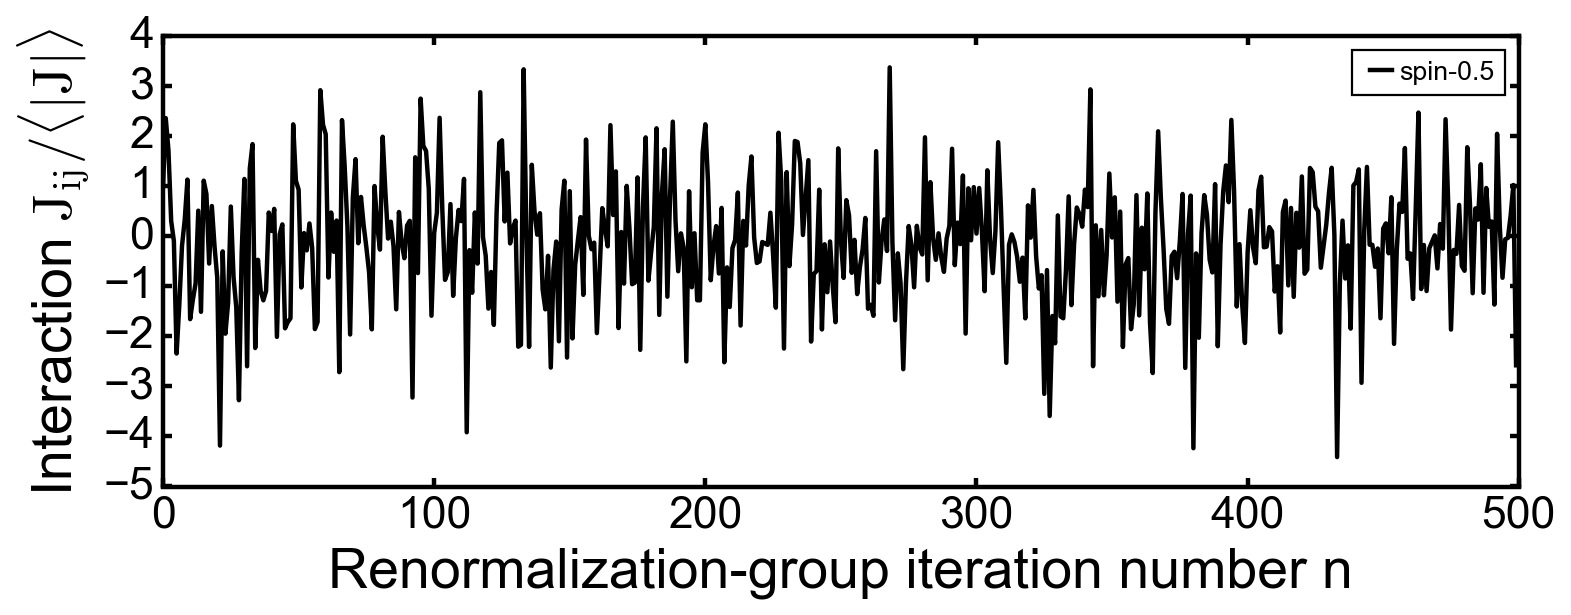

In [9]:
lw = 2
fs = 20
fig = plt.figure(figsize=(10, 4))
fig.set_facecolor('none')
plt.style.use('classic')
plt.rc('lines', linewidth=lw)
plt.rc('axes', linewidth=lw)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams.update({'mathtext.default':'regular'})

ax = plt.subplot(111)
ax.plot(flow[:,0], flow[:,1], linestyle='-', marker='', markersize=10, label="spin-" + str(s), color='black')

ax.legend(loc='upper right', ncol=1, prop={'size':fs - 8}, labelspacing=0.5, handlelength=1.4, handletextpad=0)
ax.tick_params(axis="both", direction="in", left=True, width=lw, length=4, labelsize=fs)
ax.set_xlabel(r"Renormalization-group iteration number n", fontsize=fs)
ax.set_ylabel(r"Interaction $\mathrm{J_{ij} / \langle |J| \rangle}$", fontsize=fs)
plt.tight_layout()
plt.show()
#fig.savefig('chaotic_flow', bbox_inches="tight")

# Chaos exponents

In [70]:
s = 0.5 # Spin number s
T = 0.5 # Temperature 1/J

p = 0.5 # Antiferromagnetic bond concentration
N = 500 # Bond population
n = 1000 # RG iteration number

# Ferro and antiferro transfer matrices
ferro  = rg.transfer_matrix(s,  1 / T)
aferro = rg.transfer_matrix(s, -1 / T)

t_list = []
for _ in range(int((1 - p) * N)):
    t_list.append(ferro)
for _ in range(int(p * N)):
    t_list.append(aferro)

ij = 19
j = rg.interaction(t_list[ij])
X = rg.interaction(t_list[ij]) / rg.average_interaction_strength(t_list)

print(f"""
Spin number s = {s}
Temparature 1/J = {T}
Bond population N = {N}
Antiferromagnetic bond concentration p = {p}
=============================================
""")
print("k     Lyapunov         Runaway         X")
print("_____________________________________________")
print(f"{0}     {mp.nan}              {mp.nan}             {X}")

flow = [[0, X]]
lyapunov_list = [[0, mp.nan]]
runaway_list = [[0, mp.nan]]

eps = 0.0001

for k in range(1, n):
    
    t_list_ = rg.renormalize(N, t_list, seed=19)

    # Averages: <|J|> and <|J'|>
    j_avr  = rg.average_interaction_strength(t_list)
    j_avr_ = rg.average_interaction_strength(t_list_)

    # Runaway exponent
    r = j_avr / j_avr_
    yR = mp.log(1 / r) / (mp.log(3))
    runaway_list.append([k, yR])

    # Define deviation for trajectory at step k
    delta = eps * j_avr
    tdelta = rg.transfer_matrix(s, delta)

    # Deviated t_list
    deviated_t_list = []
    for i in range(N):      
        ti = rg.mp_multiply(t_list[i], tdelta)
        deviated_t_list.append(ti)

    # Renormalize deviated transfer matrix list
    deviated_t_list_ = rg.renormalize(N, deviated_t_list, seed=19)

    # Derivation: dX(k+1)/dX(k), X(k):=J(ij)/<|J|>
    j_ = rg.interaction(t_list_[ij])
    dj_ = rg.interaction(deviated_t_list_[ij])
    j_delta = np.absolute(j_ - dj_)
    derivative = (j_delta / delta) * r

    # Log of derivative
    if derivative == 0.0 or mp.isnan(derivative):
        ly = mp.nan
        lyapunov_list.append([k, ly])
    else:
        ly = mp.log(derivative)
        lyapunov_list.append([k, ly])
    
    j_absavr_ = rg.average_interaction_strength(t_list_)
    X = j_ / j_absavr_
    flow.append([k, X])

    print(f"{k}     {mp.nstr(ly, 5)}           {mp.nstr(yR, 5)}          {mp.nstr(X, 5)}")

    # Recover the renormalized list
    t_list = t_list_


flow = np.array(flow)
lyapunov_list = np.array(lyapunov_list)
runaway_list = np.array(runaway_list)


Spin number s = 0.5
Temparature 1/J = 0.5
Bond population N = 500
Antiferromagnetic bond concentration p = 0.5

k     Lyapunov         Runaway         X
_____________________________________________
0     nan              nan             1.0
1     2.0266           0.15466          0.8436
2     1.9026           0.13324          0.31615
3     1.6103           0.14672          -0.13311
4     1.9164           0.25565          0.24098
5     1.8998           0.27063          0.37821
6     1.9404           0.23373          0.64408
7     1.9437           0.2308          2.5354
8     1.8843           0.28487          -2.1158
9     1.9092           0.26219          0.40564
10     1.9387           0.23529          0.53523
11     1.9274           0.24565          -0.80343
12     1.852           0.31422          -0.40669
13     1.9293           0.24384          0.29205
14     1.8889           0.27999          -1.0678
15     1.9063           0.26477          0.22908
16     1.9261           0.24677 

In [83]:
# Results
print(f"Lyapunov exponent = {round(lyapunov_list[100:,1].mean(), 3)}")
print(f"Runaway exponent = {round(runaway_list[100:,1].mean(), 3)}")

Lyapunov exponent = 1.923
Runaway exponent = 0.25


## Plot Lyapunov exponent convergence

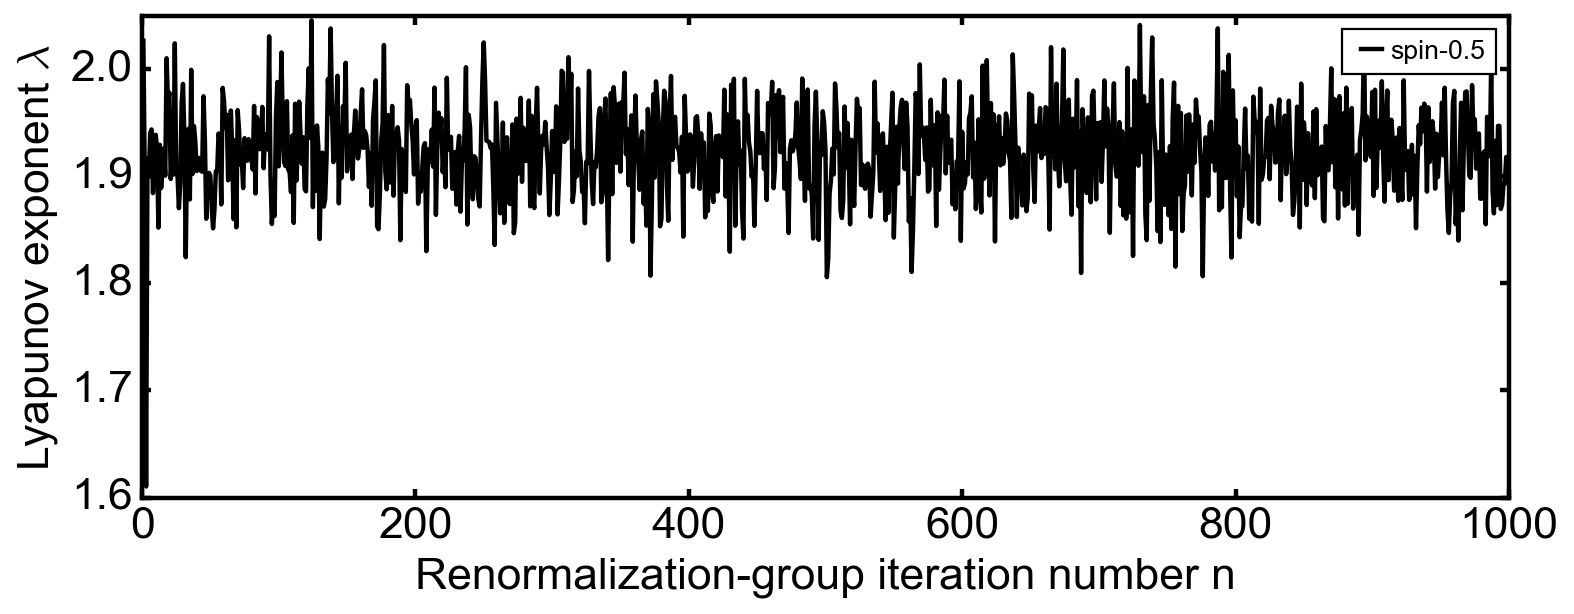

In [72]:
lw = 2
fs = 20
fig = plt.figure(figsize=(10, 4), layout='tight')
fig.set_facecolor('none')
plt.style.use('classic')
plt.rc('lines', linewidth=lw)
plt.rc('axes', linewidth=lw)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams.update({'mathtext.default':'regular'})

ax = plt.subplot(111)
ax.plot(lyapunov_list[1:,0], lyapunov_list[1:,1], linestyle='-', marker='', markersize=10, label="spin-" + str(s), color='black')
ax.legend(loc='upper right', ncol=1, prop={'size':fs - 8}, labelspacing=0.5, handlelength=1.4, handletextpad=0)
ax.tick_params(axis="both", direction="in", left=True, width=lw, length=4, labelsize=fs)
ax.set_xlabel(r"Renormalization-group iteration number n", fontsize=fs)
ax.set_ylabel(r"Lyapunov exponent $\mathrm{\lambda}$", fontsize=fs)
plt.show()
#fig.savefig('lyapunov_exponent', dpi=300)

## Plot runaway exponent convergence

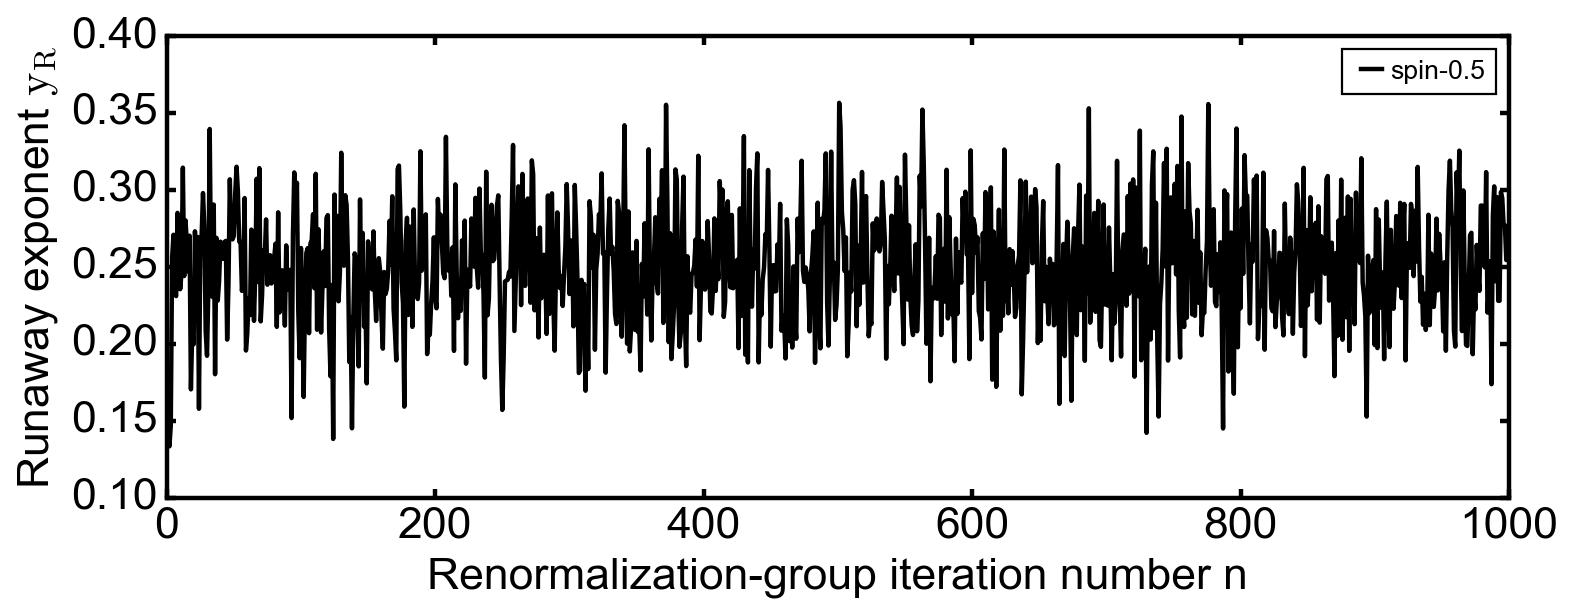

In [74]:
lw = 2
fs = 20
fig = plt.figure(figsize=(10, 4), layout='tight')
fig.set_facecolor('none')
plt.style.use('classic')
plt.rc('lines', linewidth=lw)
plt.rc('axes', linewidth=lw)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams.update({'mathtext.default':'regular'})

ax = plt.subplot(111)
ax.plot(runaway_list[1:,0], runaway_list[1:,1], linestyle='-', marker='', markersize=10, label="spin-" + str(s), color='black')
ax.legend(loc='upper right', ncol=1, prop={'size':fs - 8}, labelspacing=0.5, handlelength=1.4, handletextpad=0)
ax.tick_params(axis="both", direction="in", left=True, width=lw, length=4, labelsize=fs)
ax.set_xlabel(r"Renormalization-group iteration number n", fontsize=fs)
ax.set_ylabel(r"Runaway exponent $\mathrm{y_R}$", fontsize=fs)
plt.show()
#fig.savefig('runaway_exponent', dpi=300)